Churn analysis

В этом задании предлагается проанализировать данные одной из американских телекоммуникационных компаний о пользователях, которые потенциально могут уйти.

Измерены следующие признаки:

- state — штат США
- account_length — длительность использования аккаунта
- area_code — деление пользователей на псевдорегионы, использующееся в телекоме
- intl_plan — подключена ли у пользователя услуга международного общения
- vmail_plan — подключена ли у пользователя услуга голосовых сообщений
- vmail_message — количество голосых сообщений, который пользователь отправил / принял
- day_calls — сколько пользователь совершил дневных звонков
- day_mins — сколько пользователь проговорил минут в течение дня
- day_charge — сколько пользователь заплатил за свою дневную активность
- eve_calls, eve_mins, eve_charge — аналогичные метрики относительно вечерней активности
- night_calls, night_mins, night_charge — аналогичные метрики относительно ночной активности
- intl_calls, intl_mins, intl_charge — аналогичные метрики относительно международного общения
- custserv_calls — сколько раз пользователь позвонил в службу поддержки
- treatment — номер стратегии, которая применялись для удержания абонентов (0, 2 = два разных типа воздействия, 1 = контрольная группа)
- mes_estim — оценка интенсивности пользования интернет мессенджерами
- churn — результат оттока: перестал ли абонент пользоваться услугами оператора

In [1]:
from __future__ import division

import numpy as np
import pandas as pd
import scipy as sc

from scipy import stats
from statsmodels.stats.proportion import proportion_confint
from statsmodels.sandbox.stats.multicomp import multipletests 

from itertools import combinations

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
#reading data
churn = pd.read_csv('churn_analysis.csv')
churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 23 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      3333 non-null   int64  
 1   state           3333 non-null   object 
 2   account_length  3333 non-null   int64  
 3   area_code       3333 non-null   int64  
 4   intl_plan       3333 non-null   object 
 5   vmail_plan      3333 non-null   object 
 6   vmail_message   3333 non-null   int64  
 7   day_mins        3333 non-null   float64
 8   day_calls       3333 non-null   int64  
 9   day_charge      3333 non-null   float64
 10  eve_mins        3333 non-null   float64
 11  eve_calls       3333 non-null   int64  
 12  eve_charge      3333 non-null   float64
 13  night_mins      3333 non-null   float64
 14  night_calls     3333 non-null   int64  
 15  night_charge    3333 non-null   float64
 16  intl_mins       3333 non-null   float64
 17  intl_calls      3333 non-null   i

In [3]:
pd.set_option('display.max_columns', None)
churn.columns
churn.drop('Unnamed: 0', axis=1, inplace=True)
churn.head()

Index(['Unnamed: 0', 'state', 'account_length', 'area_code', 'intl_plan',
       'vmail_plan', 'vmail_message', 'day_mins', 'day_calls', 'day_charge',
       'eve_mins', 'eve_calls', 'eve_charge', 'night_mins', 'night_calls',
       'night_charge', 'intl_mins', 'intl_calls', 'intl_charge',
       'custserv_calls', 'treatment', 'mes_estim', 'churn'],
      dtype='object')

,state,account_length,area_code,intl_plan,vmail_plan,vmail_message,day_mins,day_calls,day_charge,eve_mins,eve_calls,eve_charge,night_mins,night_calls,night_charge,intl_mins,intl_calls,intl_charge,custserv_calls,treatment,mes_estim,churn
0,KS,128,415,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,1,0.65,False.
1,OH,107,415,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0,0.55,False.
2,NJ,137,415,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0,0.72,False.
3,OH,84,408,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,1,0.28,False.
4,OK,75,415,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,2,0.45,False.


In [4]:
churn.churn.loc[churn.churn == 'True.'] = True
churn.churn.loc[churn.churn == 'False.'] = False
churn.head()

C:\Users\LocaL\anaconda3\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,state,account_length,area_code,intl_plan,vmail_plan,vmail_message,day_mins,day_calls,day_charge,eve_mins,eve_calls,eve_charge,night_mins,night_calls,night_charge,intl_mins,intl_calls,intl_charge,custserv_calls,treatment,mes_estim,churn
0,KS,128,415,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,1,0.65,False
1,OH,107,415,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0,0.55,False
2,NJ,137,415,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0,0.72,False
3,OH,84,408,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,1,0.28,False
4,OK,75,415,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,2,0.45,False


Давайте рассмотрим всех пользователей из контрольной группы (treatment = 1). Для таких пользователей мы хотим проверить гипотезу о том, что штат абонента не влияет на то, перестанет ли абонент пользоваться услугами оператора.

Для этого мы воспользуемся критерием хи-квадрат. Построим таблицы сопряженности между каждой из всех 1275 возможных неупорядоченных пар штатов и значением признака churn. Для каждой такой таблицы 2x2 применить критерий хи-квадрат можно с помощью функции scipy.stats.chi2_contingency(subtable, correction=False).

Заметьте, что, например, (AZ, HI) и (HI, AZ) — это одна и та же пара. Обязательно выставим correction=False (о том, что это значит мы узнаем далее).

Сколько достигаемых уровней значимости оказались меньше, чем α=0.05?

In [5]:
pt_states = pd.pivot_table(churn.loc[churn.treatment == 1], values='treatment', index='state', columns='churn',
                               aggfunc=len, fill_value=0)
pt_states

churn,False,True
state,,
AK,19,1
AL,25,5
AR,11,5
AZ,17,2
CA,10,5
CO,17,5
CT,25,5
DC,18,1
DE,16,1


In [6]:
pt_states.index

Index(['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA', 'HI',
       'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN',
       'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH',
       'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VT', 'WA',
       'WI', 'WV', 'WY'],
      dtype='object', name='state')

In [7]:
chi2_val = pd.DataFrame(columns=['state 1', 'state 2', 'chi2_stat', 'p-value'])
i = 0
for st1, st2 in combinations(pt_states.index, 2):
    chi2_table = pt_states.loc[[st1, st2],:]
    chi2_val.loc[i, 'state 1'] = st1
    chi2_val.loc[i, 'state 2'] = st2
    chi2_stat = stats.chi2_contingency(chi2_table.values, correction=False)
    chi2_val.loc[i, 'chi2_stat'] = chi2_stat[0]
    chi2_val.loc[i, 'p-value'] = chi2_stat[1]
    i += 1

In [9]:
pd.set_option('display.max_rows', None)
chi2_val.head()

,state 1,state 2,chi2_stat,p-value
0,AK,AL,1.54672,0.213621
1,AK,AR,4.41,0.0357288
2,AK,AZ,0.419079,0.517397
3,AK,CA,4.84435,0.0277369
4,AK,CO,2.68864,0.101066


In [10]:
chi2_val.shape

(1275, 4)

In [11]:
sign_lvls_num = len(chi2_val.loc[chi2_val['p-value'] <= 0.05, :])
print('Num of significance lvls below 0.05: %d' % sign_lvls_num)

Num of significance lvls below 0.05: 34


В основе критерия xи-квадрат лежит предположение о том, что если верна нулевая гипотеза, то дискретное биномиальное распределение данных по клеткам в таблице сопряженности может быть аппроксимировано с помощью непрерывного распределения xи-квадрат. Однако точность такой аппроксимации существенно зависит от суммарного количества наблюдений и их распределения в этой таблице (отсюда и ограничения при использовании критерия xи-квадрат).

Одним из способов коррекции точности аппроксимации является поправка Йетса на непрерывность. Эта поправка заключается в вычитании константы 0.5 из каждого модуля разности наблюденного Oi и ожидаемого Ei значений, то есть, статистика с такой поправкой выглядит так:

χ2Yates=∑i=1N(|Oi−Ei|−0.5)2Ei.

Такая поправка, как несложно догадаться по формуле, как правило, уменьшает значение статистики χ2, то есть увеличивает достигаемый уровень значимости.

Эта поправка обычно используется для таблиц сопряженности размером 2x2 и для небольшого количества наблюдений. Такая поправка, однако, не является серебрянной пулей, и часто критикуется за то, что статистический критерий при ее использовании становится слишком консервативным, то есть часто не отвергает нулевую гипотезу там, где она неверна (совершает ошибку II рода).

Полезно знать, что эта поправка часто включена по умолчанию (например, в функции scipy.stats.chi2_contingency) и понимать ее влияние на оценку достигаемого уровня значимости.

Проведите те же самые сравнения, что и в вопросе №1, только с включенной коррекцией scipy.stats.chi2_contingency(subtable, correction=True) и сравните полученные результаты, отметив все верные варианты.

In [12]:
chi2_val = pd.DataFrame(columns=['state 1', 'state 2', 'chi2_stat', 'p-value'])
i = 0
for st1, st2 in combinations(pt_states.index, 2):
    chi2_table = pt_states.loc[[st1, st2],:]
    chi2_val.loc[i, 'state 1'] = st1
    chi2_val.loc[i, 'state 2'] = st2
    chi2_stat = stats.chi2_contingency(chi2_table.values, correction=True)
    chi2_val.loc[i, 'chi2_stat'] = chi2_stat[0]
    chi2_val.loc[i, 'p-value'] = chi2_stat[1]
    i += 1

In [13]:
chi2_val.head()

,state 1,state 2,chi2_stat,p-value
0,AK,AL,0.639205,0.423999
1,AK,AR,2.7225,0.0989429
2,AK,AZ,0.00213816,0.963119
3,AK,CA,3.05496,0.0804911
4,AK,CO,1.4358,0.230821


In [14]:
sign_lvls_num = len(chi2_val.loc[chi2_val['p-value'] <= 0.05, :])
print('Num of significance lvls below 0.05: %d' % sign_lvls_num)

Num of significance lvls below 0.05: 0


Что если у нас мало данных, мы не хотим использовать аппроксимацию дискретного распределения непрерывным и использовать сомнительную поправку, предположения критерия xи-квадрат не выполняются, а проверить гипотезу о том, что данные принадлежат одному распределению, нужно?

В таком случае прибегают к так называемому точному критерию Фишера. Этот критерий не использует приближений и в точности вычисляет значение достигаемого уровня значимости используя комбинаторный подход.

Пусть у нас есть таблица сопряженности 2x2:

Группа 1 Группа 2 Σ

Воздействие 1 a b a+b

Воздействие 2 c d c+d

Σ a+c b+d n=a+b+c+d

Тогда вероятность получить именно такие a,b,c,d при фиксированных значениях сумм по строкам и по столбцам) задается выражением

p=(a+ba)(c+dc)(na+c)=(a+b)! (c+d)! (a+c)! (b+d)!a! b! c! d! n!.

В числителе этой дроби стоит суммарное количество способов выбрать a и c из a+b и c+d соответственно. А в знаменателе — количество способов выбрать число объектов, равное сумме элементов первого столбца a+c из общего количества рассматриваемых объектов n.

Чтобы посчитать достигаемый уровень значимости критерия Фишера, нужно перебрать все возможные значения a,b,c,d, в клетках этой таблицы так, чтобы построковые и постолбцовые суммы не изменились. Для каждого такого набора a,b,c,d нужно вычислить значение pi по формуле выше и просуммировать все такие значения pi, которые меньше или равны p, которое мы вычислили по наблюдаемым значениям a,b,c,d.

Понятно, что такой критерий вычислительно неудобен в силу большого количества факториалов в формуле выше. То есть даже при небольших выборках для вычисления значения этого критерия приходится оперировать очень большими числами. Поэтому данным критерием пользуются обычно только для таблиц 2x2, но сам критерий никак не ограничен количеством строк и столбцов, и его можно построить для любой таблицы n×m.

Посчитайте для каждой пары штатов, как и в первом задании, достигаемый уровень значимости с помощью точного критерия Фишера и сравните получившиеся значения с двумя другими подходами, описанными выше.

Точный критерий Фишера удобно вычислять с помощью функции scipy.stats.fisher_exact которая принимает на вход таблицу сопряженности 2x2.

In [15]:
fisher_val = pd.DataFrame(columns=['state 1', 'state 2', 'fisher_stat', 'p-value'])
i = 0
for st1, st2 in combinations(pt_states.index, 2):
    fisher_table = pt_states.loc[[st1, st2],:]
    fisher_val.loc[i, 'state 1'] = st1
    fisher_val.loc[i, 'state 2'] = st2
    fisher_stat = stats.fisher_exact(fisher_table.values)
    fisher_val.loc[i, 'fisher_stat'] = fisher_stat[0]
    fisher_val.loc[i, 'p-value'] = fisher_stat[1]
    i += 1

In [16]:
fisher_val.head()

,state 1,state 2,fisher_stat,p-value
0,AK,AL,3.8,0.381063
1,AK,AR,8.63636,0.0688616
2,AK,AZ,2.23529,0.60499
3,AK,CA,9.5,0.0639647
4,AK,CO,5.58824,0.187034


Давайте попробуем применить полученные знания о разных видах корреляции и ее применимости на практике.

Рассмотрим пару признаков day_calls и mes_estim. Посчитайте корреляцию Пирсона между этими признаками на всех данных, ее значимость.

In [17]:
print('Pearson correlation: %.4f' % stats.pearsonr(churn.day_calls, churn.mes_estim)[0])
print('P-value: %.4f' % stats.pearsonr(churn.day_calls, churn.mes_estim)[1])

Pearson correlation: -0.0518
P-value: 0.0028


Еще раз рассмотрим пару признаков day_calls и mes_estim. Посчитайте корреляцию Спирмена между этими признаками на всех данных, ее значимость.

In [18]:
print('Spearman correlation: %.4f' % stats.spearmanr(churn.day_calls, churn.mes_estim)[0])
print('P-value: %.4f' % stats.spearmanr(churn.day_calls, churn.mes_estim)[1])

Spearman correlation: 0.0433
P-value: 0.0123


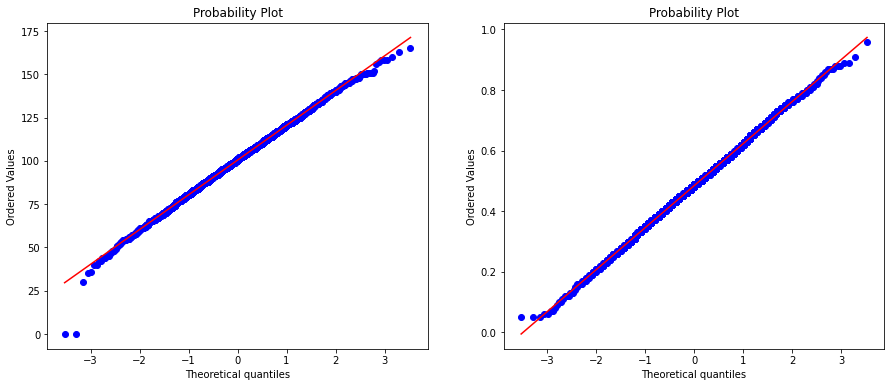

In [19]:
_ = plt.figure(figsize=(15,6))
_ = plt.subplot(121)
_ = sc.stats.probplot(churn.day_calls, dist="norm", plot=plt)
_ = plt.subplot(122)
_ = sc.stats.probplot(churn.mes_estim, dist="norm", plot=plt)

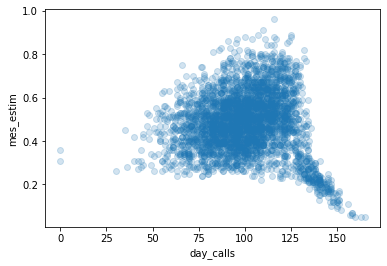

In [20]:
_ = plt.scatter(churn.day_calls, churn.mes_estim, alpha=0.2)
_ = plt.xlabel('day_calls')
_ = plt.ylabel('mes_estim')

Посчитайте значение коэффицента корреляции Крамера между двумя признаками: штатом (state) и оттоком пользователей (churn) для всех пользователей, которые находились в контрольной группе (treatment=1). Что можно сказать о достигаемом уровне значимости при проверке гипотезы о равенство нулю этого коэффициента?

In [21]:
def cramers_stat(confusion_matrix):
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    return np.sqrt(chi2 / (n*(min(confusion_matrix.shape)-1)))

In [22]:
print('V Cramer stat value: %.4f' % cramers_stat(pt_states.values))

V Cramer stat value: 0.2004


In [23]:
print('p-value: %.4f' % stats.chi2_contingency(pt_states.values)[1])

p-value: 0.7098


Вы прослушали большой курс и к текущему моменту обладете достаточными знаниями, чтобы попытаться самостоятельно выбрать нужный метод / инструмент / статистический критерий и сделать правильное заключение.

В этой части задания вам нужно будет самостоятельно решить, с помощью каких методов можно провести анализ эффективности удержания (churn) с помощью раличных методов (treatment = 0, treatment = 2) относительно контрольной группы пользователей (treatment = 1).

Что можно сказать об этих двух методах (treatment = 0, treatment = 2)? Одинаковы ли они с точки зрения эффективности? Каким бы методом вы бы посоветовали воспользоваться компании?

Не забудьте про поправку на множественную проверку! И не пользуйтесь односторонними альтернативами, поскольку вы не знаете, к каким действительно последствиям приводят тестируемые методы (treatment = 0, treatment = 2)!

In [24]:
pt_states = pd.pivot_table(churn, values='account_length', index='state', columns=['treatment', 'churn'],
                               aggfunc=len, fill_value=0)
pt_states

treatment     0           1           2      
churn     False True  False True  False True 
state                                        
AK           15     2    19     1    15     0
AL           22     1    25     5    25     2
AR           14     3    11     5    19     3
AZ           26     0    17     2    17     2
CA           10     3    10     5     5     1
CO           20     2    17     5    20     2
CT           22     3    25     5    15     4
DC           19     3    18     1    12     1
DE           18     4    16     1    18     4
FL           16     4    18     2    21     2
GA           11     5    19     2    16     1
HI           17     1    12     1    21     1
IA           13     1    13     2    15     0
ID           22     6    16     2    26     1
IL           25     2    11     1    17     2
IN           22     4    20     3    20     2
KS           21     2    18     7    18     4
KY           18     2    21     4    12     2
LA           11     1    15     0    21     3
MA           20     2    17     7    17     2
MD           11     6    19     5    23     6
ME           14     4    20     8    15     1
MI           22     6    17     5    18     5
MN           28     6    19     2    22     7
MO           22     1    17     4    17     2
MS           15     9    20     4    16     1
MT           19     6    22     4    13     4
NC           21     4    16     3    20     4
ND           17     2    21     3    18     1
NE           16     1    21     3    19     1
NH           20     3    10     2    17     4
NJ           12     7    20     4    18     7
NM           14     3    27     2    15     1
NV           11     3    18     6    23     5
NY           22     4    27     6    19     5
OH           25     3    22     2    21     5
OK           19     1    11     2    22     6
OR           18     7    18     3    31     1
PA           13     3    14     4    10     1
RI           15     1    18     4    26     1
SC           15     3    16     5    15     6
SD           19     2    20     3    13     3
TN           18     1    11     1    19     3
TX           26     7    14     6    14     5
UT           23     4    18     4    21     2
VA           22     2    20     3    30     0
VT           24     1    18     5    23     2
WA           20     4    16     7    16     3
WI           25     4    22     2    24     1
WV           37     2    27     5    32     3
WY           23     4    20     2    25     3

In [25]:
#proportions of churn = 1 for each treatment
props_churn = np.array([pt_states.loc[:, treat].loc[:, True].sum() / 
                        (pt_states.loc[:, treat].loc[:, False].sum() + pt_states.loc[:, treat].loc[:, True].sum())
                        for treat in range(3)])
for i, prop in enumerate(props_churn):
    print('Treatment #%d prop. of churn = 1: %.4f' % (i, prop))

Treatment #0 prop. of churn = 1: 0.1456
Treatment #1 prop. of churn = 1: 0.1641
Treatment #2 prop. of churn = 1: 0.1251


In [26]:
#wilson intervals for proportions
wilson_ints = np.array([proportion_confint(pt_states.loc[:, treat].loc[:, True].sum(),
                                           (pt_states.loc[:, treat].loc[:, False].sum() + pt_states.loc[:, treat].loc[:, True].sum()),
                                           method='wilson') for treat in range(3)])
for i, wils in enumerate(wilson_ints):
    print('Treatment #%d prop. of churn = 1: %s' % (i, str(wils)))

Treatment #0 prop. of churn = 1: [0.12628913 0.16736788]
Treatment #1 prop. of churn = 1: [0.14334707 0.18716506]
Treatment #2 prop. of churn = 1: [0.1068801  0.14594876]


In [27]:
def proportions_confint_diff_ind(sample1, sample2, alpha = 0.05):    
    z = stats.norm.ppf(1 - alpha / 2.)
    l1 = sample1.loc[:, False].sum() + sample1.loc[:, True].sum()
    l2 = sample2.loc[:, False].sum() + sample2.loc[:, True].sum()
    p1 = sample1.loc[:, True].sum() / l1
    p2 = sample2.loc[:, True].sum() / l2
    
    left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1)/ l1 + p2 * (1 - p2)/ l2)
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1)/ l1 + p2 * (1 - p2)/ l2)
    
    return (left_boundary, right_boundary)

In [28]:
def proportions_diff_z_stat_ind(sample1, sample2):
    l1 = sample1.loc[:, False].sum() + sample1.loc[:, True].sum()
    l2 = sample2.loc[:, False].sum() + sample2.loc[:, True].sum()
    p1 = sample1.loc[:, True].sum() / l1
    p2 = sample2.loc[:, True].sum() / l2
    P = (p1*l1 + p2*l2) / (l1 + l2)
    
    return (p1 - p2) / np.sqrt(P * (1 - P) * (1. / l1 + 1. / l2))

In [29]:
def proportions_diff_z_test(z_stat, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    if alternative == 'two-sided':
        return 2 * (1 - stats.norm.cdf(np.abs(z_stat)))
    
    if alternative == 'less':
        return stats.norm.cdf(z_stat)

    if alternative == 'greater':
        return 1 - stats.norm.cdf(z_stat)

In [30]:
p_val_table = np.empty((3, 3))
i = 0
for tr1, tr2 in combinations(range(3), 2):
    print('Treatments #%d and %d: ' % (tr1, tr2)),
    confint_diff = proportions_confint_diff_ind(pt_states.loc[:, tr1], pt_states.loc[:, tr2])
    print('[%.4f, %.4f], ' % confint_diff),
    p_val = proportions_diff_z_test(proportions_diff_z_stat_ind(pt_states.loc[:, tr1], pt_states.loc[:, tr2]))
    p_val_table[i, :] = tr1, tr2, p_val
    i += 1
    print('p-value: %.4f' % p_val)
p_val_table

Treatments #0 and 1: 


(None,)

[-0.0485, 0.0116], 


(None,)

p-value: 0.2283
Treatments #0 and 2: 


(None,)

[-0.0078, 0.0489], 


(None,)

p-value: 0.1564
Treatments #1 and 2: 


(None,)

[0.0096, 0.0683], 


(None,)

p-value: 0.0093


array([[0.        , 1.        , 0.22833116],
       [0.        , 2.        , 0.15642469],
       [1.        , 2.        , 0.00934808]])

In [31]:
_, p_corrected, _, _ = multipletests(p_val_table[:,2], alpha = 0.05, method = 'fdr_bh') 
p_corrected

array([0.22833116, 0.22833116, 0.02804425])